<a href="https://colab.research.google.com/github/YShu7/FYP/blob/master/exp/final/%5Bv3_2%5DLSTM_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up

In [ ]:
%load_ext autoreload
%autoreload 2
import sqlite3
import operator
import pandas as pd
import collections
import networkx as nx
import json
import math
import numpy as np
from multiprocessing import Pool
from scipy.optimize import linear_sum_assignment
import time
import utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

torch.manual_seed(1)
torch.set_deterministic(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


In [ ]:
INTERVAL = 60
TIME_PERIOD = 1
SCALE_METERS = 15000
scaleMeters = SCALE_METERS * 0.2
SIGMA_V = scaleMeters / 100
IMPOSSIBLE = 1e-10
MINUTE = 10
UPDATE_TIME = MINUTE * INTERVAL

N, M = 30, 91
PATH = '/content/drive/MyDrive/FYP'
TRAIN_DB = 'database_100+_train_2.db'
TEST_DB = 'database_100-_test_2.db'
MODEL_PATH = 'e950_regre_2.pkl' #'e400_bi_regre_2.pkl' #'e700_regre.pkl'#'e600_bi_regre.pkl'

EMBEDDING_DIM = 32
HIDDEN_DIM = 128
INPUT_DIM = 10

# Train

In [ ]:
cnx = sqlite3.connect(f'{PATH}/{TRAIN_DB}')

df_walks = pd.read_sql_query("SELECT * FROM walks JOIN walkers ON walkers.id = walks.walker_id", cnx)
df_walkers = pd.read_sql_query("SELECT * FROM walkers", cnx)
df_agents = pd.read_sql_query("SELECT * FROM agents", cnx)
df_contacts_tmp = pd.read_sql_query("SELECT * FROM contacts JOIN walkers ON walkers.id = contacts.walker_id", cnx)
idx = df_contacts_tmp.groupby(['walker_id', 'time'])['distance'].transform(min) == df_contacts_tmp['distance']
df_contacts = df_contacts_tmp[idx]

In [ ]:
id_to_pos, pos_to_id = utils.get_position(df_agents)

In [ ]:
prob_agent_id, prob_dir, prob_move = utils.get_agent_next_prob(df_walkers, df_contacts, df_agents['id'].tolist())

In [ ]:
prob_pos = utils.map_prob_to_pos(prob_agent_id, id_to_pos)

In [ ]:
len(set(df_contacts['walker_id']))

9016

# Define Model

In [ ]:
DEBUG = False

agent_to_ix = {}
for _, row in df_agents.iterrows():
  x, y = row['id'].split('EVEN')
  agent_to_ix[row['id']] = [int(x)/N, (int(y)%M)/M]

#### Single

In [ ]:
class LSTMTagger(nn.Module):

  def __init__(self, input_dim, embedding_dim, hidden_dim, num_classes, num_layers=1, seq_len=10):
    super(LSTMTagger, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.embedding_dim = embedding_dim


    # LSTM
    self.lstm = nn.LSTM(2, hidden_dim, num_layers=num_layers, batch_first=True) #lstm
    self.lstm_1 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
    self.fc_1 = nn.Linear(hidden_dim, hidden_dim)
    self.fc = nn.Linear(hidden_dim, 2)
    self.relu = nn.ReLU() 

  def forward(self, input):
    # INPUT: (batch, seq_len)
    if DEBUG: print('input: ', input.shape)

    # LSTM
    # LSTM: (batch, seq, feature)
    lstm, (hn, cn) = self.lstm(input)
    lstm = nn.Dropout(0.2)(lstm)
    if DEBUG: print('lstm:', lstm.shape)

    lstm_1, (hn, cn) = self.lstm_1(lstm)
    hn = nn.Dropout(0.2)(hn)
    hn = hn.view(-1, self.hidden_dim)
    if DEBUG: print('hn:', hn.shape)

    out = self.fc_1(hn).to(device) #first Dense
    if DEBUG: print('fc_1:', out.shape)
    out = self.relu(out).to(device) #relu

    out = self.fc(out).to(device)

    return out

#### Bidirectional

In [ ]:
# DEBUG = False
# class LSTMTagger(nn.Module):

#   def __init__(self, input_dim, embedding_dim, hidden_dim, num_classes, num_layers=1, seq_len=10):
#     super(LSTMTagger, self).__init__()
#     self.hidden_dim = hidden_dim
#     self.num_layers = num_layers
#     self.embedding_dim = embedding_dim


#     # LSTM
#     self.lstm = nn.LSTM(2, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True) #lstm
#     self.lstm_1 = nn.LSTM(hidden_dim*2, hidden_dim, bidirectional=True, batch_first=True)
#     self.fc_1 = nn.Linear(hidden_dim*2, hidden_dim)
#     self.fc = nn.Linear(hidden_dim, 2)
#     self.relu = nn.ReLU() 

#   def forward(self, input):
#     # INPUT: (batch, seq_len)
#     if DEBUG: print('input: ', input.shape)

#     # LSTM
#     # LSTM: (batch, seq, feature)
#     lstm, (hn, cn) = self.lstm(input)
#     lstm = nn.Dropout(0.2)(lstm)
#     if DEBUG: print('lstm:', lstm.shape)

#     lstm_1, (hn, cn) = self.lstm_1(lstm)
#     hn = nn.Dropout(0.2)(hn)
#     if DEBUG: print('hn:', hn.shape)
#     hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
#     # hn = hn.view(-1, self.hidden_dim)
#     if DEBUG: print('hn:', hn.shape)

#     out = self.fc_1(hn).to(device) #first Dense
#     if DEBUG: print('fc_1:', out.shape)
#     out = self.relu(out).to(device) #relu

#     out = self.fc(out).to(device)

#     return out


## Predicating

In [ ]:
cnx = sqlite3.connect(f'{PATH}/{TEST_DB}')

df_walks = pd.read_sql_query("SELECT * FROM walks JOIN walkers ON walkers.id = walks.walker_id", cnx)
df_walkers = pd.read_sql_query("SELECT * FROM walkers", cnx)
df_agents = pd.read_sql_query("SELECT * FROM agents", cnx)
df_contacts_tmp = pd.read_sql_query("SELECT * FROM contacts JOIN walkers ON walkers.id = contacts.walker_id", cnx)
idx = df_contacts_tmp.groupby(['walker_id', 'time'])['distance'].transform(min) == df_contacts_tmp['distance']
df_contacts = df_contacts_tmp[idx]

In [ ]:
"""
Get counter of agent_id Key -> agent_id Values
"""
id_to_pos, pos_to_id = utils.get_position(df_agents)
prob_agent_id = utils.map_prob_to_agent_id(prob_pos, pos_to_id)

## Time based

In [ ]:
walker_ids = set(df_contacts['walker_id'].tolist())
id_to_time = {}
id_to_agent = {}
start_time_to_id = collections.defaultdict(list)
end_time_to_id = collections.defaultdict(list)
for walker_id in walker_ids:
    candidates = df_contacts.loc[df_contacts['walker_id'] == walker_id].sort_values('time')
    min_time, max_time = candidates.iloc[0]['time'], candidates.iloc[-1]['time']
    id_to_time[walker_id] = (int(min_time), int(max_time))
    id_to_agent[walker_id] = (candidates.iloc[0]['agent_id'], candidates.iloc[-1]['agent_id'])
    start_time_to_id[int(min_time)].append(walker_id)
    end_time_to_id[int(max_time)].append(walker_id)

In [ ]:
walker_ids = set(df_contacts['walker_id'].tolist())
link_list = {}
for walker_id in walker_ids:
    last_time = id_to_time[walker_id][1]
    candidates = start_time_to_id[last_time + INTERVAL]

    if len(candidates) == 1:
        x0, y0 = id_to_agent[walker_id][1].split('EVEN')
        x1, y1 = id_to_agent[candidates[0]][0].split('EVEN')
        if abs(int(x0) - int(x1)) <= 1 and abs(int(y0)%30 - int(y1)%30) <= 1:
            link_list[walker_id] = candidates[0]
print(len(walker_ids))
print(link_list)

2076
{'ydimBegtbELklwWvzVPV': 'JyrxSGOkIiIYaiCsWrew', 'joXrzjFXZtrSHwyEvhJH': 'BLbZbMTnXUwsnQNMyFCQ', 'ooslLnJytTqSWQxMnKPp': 'ZlzRImiUJHXhFQofUkLe', 'ETTlNQiXJWAYFKeCPEvJ': 'txbvGKQDTFYuCRXBbysY', 'wiQwSksxDLtVTITKuOzz': 'pYamDoBbgAsksMsouKXY', 'FggtkukJjwFDkQZtNMXi': 'QzCBcICYCOfszhCLQcTn', 'XjykuzHgrYMKLAXymOZa': 'MHgUflnDWdcghcOPtizn', 'EOZSckGLPGviAkNBdLLg': 'FyCtafqopugFwSbgBfgT', 'ollroajPxPLxFXExCGGX': 'UfbYyiupbbmMnVstSnXw', 'jgGlwAPFhfPINUnxpivb': 'THqFxavIdjyxOGoefEEU', 'LTSEPmwNNjpqrsTHIylp': 'hEgYmgnYoDTKcvGsKRyx', 'ayorIsRftPELTZpNLehN': 'gcdENmDRsDrnYrtVHrOL', 'tbnMtFMcsCSTiVtnXyuU': 'wMkeUuEJggBsgVLZKqDN', 'DWHNkwigfJlAwmIUPWyJ': 'AzIOUrHSmEYbOIQfcTmV', 'asLprNqnNZGuGTryDYDp': 'ctEnnvnHOiaLZGbihsHc', 'fEBekuriCOsCbIcIwcte': 'hmPfyYYaxtOagzQsXTdb', 'fiPWfFKpoJWlnTHuZzBT': 'hnYPvKELaQBqNQetDEpD', 'EuEymOOwUtiWRdiSaVVV': 'yJhvOGMcFCxbjYNMvHes', 'qyGYiobckHcHTLuhWtXv': 'WbPRSUGimXBVVxHjhCoX', 'HtjxpEoWdtLuayfBspHa': 'jrJJcgpjdFGHtuZmPISp', 'YxyMtFRwuZuINccjWTiV': 'QOFYhALnq

In [ ]:
"""
Connect each linked path into a single path
"""
graph = nx.Graph([(i, j) for i, j in link_list.items() if i and j])
connected_components = sorted(nx.connected_components(graph), key=len, reverse=True)
print(len(connected_components))
print(connected_components)

tried = 0
df_walks_connected = pd.DataFrame(df_walks)
for i, component in enumerate(connected_components):
    new_id = i
    time_set = set()
    for c in component:
        df_walks_connected = df_walks_connected.replace({'walker_id': {c: str(new_id) + 'res'}})
        

317
[{'wQuSzYXPjiKoNdTFxaCs', 'BRCGJVcEQOPoMLcYfIZm', 'vKtAsUvrCYkkOqWpOyQM', 'XunIltxBUSUEVZWkBuXh', 'roFWABfthtSgIODCLhuN', 'BsqdjugaAhDsRVSlrEdj', 'ywcbPuPsOQmLMaMPZRay', 'lJmcnerygyNMObbcqFej', 'zmCFbVECCffUVIuKWMfn', 'hIcROuRxBnanXDhsdCwj', 'mSmQjsxxUqExZkKKBdsg', 'lMHeubwUqMYxsSbqnoij', 'PAhCSwUBzYNrjYQiopaM', 'VjBHyZckWIFWQwYJDgWZ', 'kGAtfKatqdxOyuRFWGAL', 'tcDNflGxrbhtobiCHTmU', 'KVxrBjXBkkNnvELAdpuh', 'XKiJNQuwyepzmvXrKIGU', 'PrWAceZrUaMXvuEYVKQX', 'nUoOZstxszBlCNuaTvbq', 'vyDDgCzmzzdzfYwoQAwR'}, {'gpmcHMSJxPwNvHmDaNWv', 'JphaoVPWHtQDWfcrMuuY', 'wfTcrPaDEnLDisWtzrMQ', 'dAXoRtYJWdzQGsUzmKjs', 'tzJkOnKtPBHlvXIufdGW', 'lUyVdBDqUVLzdKjvXivg', 'QYvpelzBBQjzwOxhADne', 'YVUdUepkajtBpnChxkWe', 'wIiueFaoeCQsYJhYLBWz', 'cNIezaofMDkDGuLGAqAs', 'qvTsgJLyRdyruCGTpCTJ', 'EfRndqEWcOLHsueHdGmr', 'jyYmcHFamZqQjYUhUJfl', 'wEzVsoYfTjMHhgNXoOvQ', 'gxrWChhHXsjVQADRjmfK', 'GMSYRKQOEyTkArwVgqhP', 'swWbFwYfZZAVadEBxMXt', 'JtofFrYPuMTBIFzrjNQb', 'QcuLtvVVowUpRMVuxvjY', 'nXZnuMaYswSLNghhPUdM', 'cqOYRFD

In [ ]:
"""
Precision: How much percentage of the grouped ids are really from one group
"""

DEBUG = True
walker_ids = list(set(df_walks_connected['walker_id'].tolist()))
real_ids = list(set(df_walks_connected['real_id'].tolist()))

matrix = [[0] * len(real_ids) for _ in range(len(walker_ids))]

if DEBUG: print(len(walker_ids))
    
for i, walker_id in enumerate(walker_ids):
    id_list = df_walks_connected.loc[df_walks_connected['walker_id'] == walker_id]['real_id'].tolist()
    dic = collections.Counter(id_list)
    
    for j, real_id in enumerate(real_ids):
      matrix[i][j] = -dic[real_id] if real_id in dic else 0
    
matrix = np.array(matrix)
row_ind, col_ind = linear_sum_assignment(matrix) 
print(len(walker_ids), len(real_ids), len(row_ind), len(col_ind))  

correct = -matrix[row_ind, col_ind].sum()
total = df_walks_connected.shape[0]

walker_acc = 0
for i, r in enumerate(row_ind):
  walker_acc += matrix[r][col_ind[i]] / sum(matrix[r])

real_acc = 0
accept_num = 0
for i, c in enumerate(col_ind):
  rate = matrix[row_ind[i]][c] / sum([matrix[j][c] for j in range(len(walker_ids))])
  real_acc += rate
  accept_num += 1 if rate > 0.6 else 0
# print(f'correct/tried: {correct}/{tried} {correct/tried*100}%') 
print(f'correct/total: {correct}/{total} {correct/total*100}%')
print(f'accuracy: {walker_acc/len(walker_ids)*100}')
print(f'precision: {real_acc/len(real_ids)*100}')
print(f'accept rate: {accept_num/len(real_ids)*100}')

684
684 100 100 100
correct/total: 9040/19727 45.825518325138134%
accuracy: 14.501628975313185
precision: 45.932095035061124
accept rate: 26.0


## Model helper

In [ ]:
def prepare_data_test(walk, num_steps, to_ix):
    path = []

    for i, row in walk.iterrows():
        path.append(to_ix[row['agent_id']])
    for _ in range(num_steps - 1):
        path.append(to_ix[walk.iloc[-1]['agent_id']])

    return torch.Tensor([path]).type(torch.FloatTensor)

import math
walker_ids = set(df_contacts['walker_id'])
print(len(walker_ids))

2076


In [ ]:
def compute_proba(df_contacts, walker_id1, walk, num_steps, candidates, prob_agent_id, prob_dir, prob_move, clf=None):
    candidate_agent_probs = {}

    output = model(prepare_data_test(walk, num_steps, agent_to_ix))[0] #forward pass
    output = [round(float(output[0])*N), round(float(output[1])*M)]
    for _, candidate in candidates.iterrows():
        x, y = agent_to_ix[candidate['agent_id']]
        prob = 1 - 1 / math.sqrt(N**2 + M**2) * math.sqrt((int(x) - output[0])**2 + (int(y) - output[1])**2)
        # prob = max(prob, 1e-32)
        candidate_agent_probs[candidate['walker_id']] = prob
    
    sum_prob = sum(candidate_agent_probs.values())
    for k, v in candidate_agent_probs.items():
      candidate_agent_probs[k] = candidate_agent_probs[k] / sum_prob
     
    return candidate_agent_probs

In [ ]:
walker_ids = set(df_contacts['walker_id'].tolist())
id_to_time = {}
id_to_agent = {}
start_time_to_id = collections.defaultdict(list)
end_time_to_id = collections.defaultdict(list)
for walker_id in walker_ids:
    candidates = df_contacts.loc[df_contacts['walker_id'] == walker_id].sort_values('time')
    min_time, max_time = candidates.iloc[0]['time'], candidates.iloc[-1]['time']
    id_to_time[walker_id] = (int(min_time), int(max_time))
    id_to_agent[walker_id] = (candidates.iloc[0]['agent_id'], candidates.iloc[-1]['agent_id'])
    start_time_to_id[int(min_time)].append(walker_id)
    end_time_to_id[int(max_time)].append(walker_id)

### Method 1

In [ ]:
# from scipy.optimize import linear_sum_assignment
# import math

# link_list, reversed_link_list = {}, {}
# DEBUG = False
# """
# Map agent id to its most possible next agent.
# """
# no_candidates = 0
# model = LSTMTagger(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, len(agent_to_ix)).to(device)
# model.load_state_dict(torch.load(f'{MODEL_PATH}', map_location=torch.device('cpu')))
# model.train(False)
# walker_ids, sorted_walker_ids = set(), []

# for _, row in df_contacts.sort_values('time').iterrows():
#   if row['walker_id'] in walker_ids:
#     continue
#   sorted_walker_ids.append(row['walker_id'])
#   walker_ids.add(row['walker_id'])

# visited_walker_ids = set()
# for i, walker_id1 in enumerate(walker_ids):
#     if walker_id1 in visited_walker_ids:
#         continue
#     if i % 500 == 499:
#         print(f'{i+1}...')
#     walk = df_contacts.loc[df_contacts['walker_id'] == walker_id1].sort_values('time')
 
#     time = walk.iloc[-1]['time']
#     # get candidate points by time

#     candidate_ids = start_time_to_id[time + INTERVAL]
#     for id in end_time_to_id[time]:
#       if id != walker_id and id in candidate_ids:
#         candidate_ids.remove(id)
#     # sum([1 if id != walker_id else 0 for id in end_time_to_id[time]])
#     next_time = time + INTERVAL
#     candidates = df_contacts.loc[(df_contacts['walker_id'].isin(candidate_ids)) & (df_contacts['time'] == next_time)]
#     # print(candidates)
 
#     if candidates.shape[0] == 0:
#         candidate_ids = start_time_to_id[time + 2 * INTERVAL]
#         next_time += INTERVAL
#         for id in end_time_to_id[time + INTERVAL]:
#           if id != walker_id and id in candidate_ids:
#             candidate_ids.remove(id)
#         candidates = df_contacts.loc[(df_contacts['walker_id'].isin(candidate_ids)) & (df_contacts['time'] == next_time)]

#         if candidates.shape[0] == 0:
#           candidate_ids = start_time_to_id[time + 3 * INTERVAL]
#           next_time += INTERVAL
#           for id in end_time_to_id[time + 2 * INTERVAL]:
#             if id != walker_id and id in candidate_ids:
#               candidate_ids.remove(id)
#           candidates = df_contacts.loc[(df_contacts['walker_id'].isin(candidate_ids)) & (df_contacts['time'] == next_time)]

#         if candidates.shape[0] == 0:
#             no_candidates += 1
#             continue
 
#     # if candidates.shape[0] == 1:
#     #     # print('1 candidates')
#     #     link_list[walker_id] = candidates.iloc[-1]['walker_id']
#     #     visited_walker_ids.add(walker_id)
#     #     continue
        
#     raw_batch_walker_ids = set(df_contacts.loc[df_contacts['time'] == time]['walker_id'])
#     batch_walker_ids_prob = {}
#     for walker_id2 in raw_batch_walker_ids:
#         walk2 = df_contacts.loc[df_contacts['walker_id'] == walker_id2].sort_values('time')
#         if int(walk2.iloc[-1]['time']) == time and walker_id2 not in visited_walker_ids:
#             if walker_id2 in reversed_link_list:
#                 walk2 = df_contacts.loc[df_contacts['walker_id'].isin([walker_id2, reversed_link_list[walker_id2]])].sort_values('time')
#             batch_walker_ids_prob[walker_id2] = compute_proba(df_contacts, walker_id2, walk2, int((next_time - walk2.iloc[-1]['time']) / INTERVAL), candidates, prob_agent_id, prob_dir, prob_move)
 
#     # print(batch_walker_ids_prob)
#     walker_id_to_index, walker_index_to_id = {}, []
#     candidate_id_to_index, candidate_index_to_id = {}, []
 
#     for k, values in batch_walker_ids_prob.items():
#         walker_id_to_index[k] = len(walker_id_to_index)
#         walker_index_to_id.append(k)
#         for c, v in values.items():
#             if c not in candidate_id_to_index:
#                 candidate_id_to_index[c] = len(candidate_id_to_index)
#                 candidate_index_to_id.append(c)
#     matrix = [[1e-32] * len(candidate_id_to_index) for _ in range(len(walker_id_to_index))]
    
#     for k, values in batch_walker_ids_prob.items():
#         for c, v in values.items():
#             matrix[walker_id_to_index[k]][candidate_id_to_index[c]] = -math.log(v)
                
#     # print(matrix)
#     row_ind, col_ind = linear_sum_assignment(matrix)
#     # print(matrix)
#     for row_idx, col_idx in zip(row_ind, col_ind):
#         if matrix[row_idx][col_idx] >= -math.log(1e-32):
#             continue
#         link_list[walker_index_to_id[row_idx]] = candidate_index_to_id[col_idx]
#         reversed_link_list[candidate_index_to_id[col_idx]] = walker_index_to_id[row_idx]
#         visited_walker_ids.add(walker_index_to_id[row_idx])

### Method 2

In [ ]:
from scipy.optimize import linear_sum_assignment
import math

link_list, reversed_link_list = {}, {}
DEBUG = False
"""
Map agent id to its most possible next agent.
"""
no_candidates = 0
model = LSTMTagger(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, len(agent_to_ix)).to(device)
model.load_state_dict(torch.load(f'{MODEL_PATH}', map_location=torch.device('cpu')))
model.train(False)

walker_ids, sorted_walker_ids = set(), []

visited_walker_ids = set()

times = sorted(list(end_time_to_id.keys()))
for i, time in enumerate(times):
    # (time, raw_batch_walker_ids) in enumerate(end_time_to_id.items()):
    raw_batch_walker_ids = end_time_to_id[time]
    if len(raw_batch_walker_ids) == 0:
        no_candidates += 1
        continue
    if i % 500 == 499:
        print(f'{i+1}...')

    candidate_ids = start_time_to_id[time + INTERVAL]
    next_times = [time + INTERVAL]
    candidates = df_contacts.loc[(df_contacts['walker_id'].isin(candidate_ids)) & (df_contacts['time'].isin(next_times))]

    if len(candidate_ids) < len(raw_batch_walker_ids):
        candidate_ids += start_time_to_id[time + 2 * INTERVAL]
        next_times.append(time + 2 * INTERVAL)
        candidates = df_contacts.loc[(df_contacts['walker_id'].isin(candidate_ids)) & (df_contacts['time'].isin(next_times))]

        if len(candidate_ids) < len(raw_batch_walker_ids):
          candidate_ids += start_time_to_id[time + 3 * INTERVAL]
          next_times.append(time + 3 * INTERVAL)
          candidates = df_contacts.loc[(df_contacts['walker_id'].isin(candidate_ids)) & (df_contacts['time'].isin(next_times))]

        if candidates.shape[0] == 0:
            no_candidates += 1
            continue
 
    batch_walker_ids_prob = {}
    for walker_id2 in raw_batch_walker_ids:
        walk2 = df_contacts.loc[df_contacts['walker_id'] == walker_id2].sort_values('time')
        tmp = walker_id2
        if int(walk2.iloc[-1]['time']) == time and walker_id2 not in visited_walker_ids:
            walker_id2s = [walker_id2]
            while walker_id2 in reversed_link_list:
                walker_id2 = reversed_link_list[walker_id2]
                walker_id2s.append(walker_id2)
            walk2 = df_contacts.loc[df_contacts['walker_id'].isin(walker_id2s)].sort_values('time')
            if walk2.iloc[-1]['walker_id'] != tmp:
              print("ERROR!")
            batch_walker_ids_prob[walk2.iloc[-1]['walker_id']] = compute_proba(df_contacts, walk2.iloc[-1]['walker_id'], walk2, int((walk2.iloc[-1]['time'] - walk2.iloc[-1]['time']) / INTERVAL), candidates, prob_agent_id, prob_dir, prob_move)
 
    walker_id_to_index, walker_index_to_id = {}, []
    candidate_id_to_index, candidate_index_to_id = {}, []
 
    for k, values in batch_walker_ids_prob.items():
        walker_id_to_index[k] = len(walker_id_to_index)
        walker_index_to_id.append(k)
        for c, v in values.items():
            if c not in candidate_id_to_index:
                candidate_id_to_index[c] = len(candidate_id_to_index)
                candidate_index_to_id.append(c)
    matrix = [[1e-32] * len(candidate_id_to_index) for _ in range(len(walker_id_to_index))]
    
    for k, values in batch_walker_ids_prob.items():
        for c, v in values.items():
            matrix[walker_id_to_index[k]][candidate_id_to_index[c]] = -math.log(v)
                
    # print(matrix)
    row_ind, col_ind = linear_sum_assignment(matrix)
    # print(matrix)
    for row_idx, col_idx in zip(row_ind, col_ind):
        if matrix[row_idx][col_idx] >= -math.log(1e-32):
            continue
        link_list[walker_index_to_id[row_idx]] = candidate_index_to_id[col_idx]
        reversed_link_list[candidate_index_to_id[col_idx]] = walker_index_to_id[row_idx]
        visited_walker_ids.add(walker_index_to_id[row_idx])
        

500...
1000...
1500...


In [ ]:
no_candidates

95

In [ ]:
"""
Connect each linked path into a single path
"""
graph = nx.Graph([(i, j) for i, j in link_list.items() if i and j])
connected_components = sorted(nx.connected_components(graph), key=len, reverse=True)
print(len(connected_components))
print(connected_components)

tried = 0
df_walks_connected = pd.DataFrame(df_walks)
for i, component in enumerate(connected_components):
    new_id = i
    time_set = set()
    for c in component:
        df_walks_connected = df_walks_connected.replace({'walker_id': {c: str(new_id) + 'res'}})
        

104
[{'MtrXAPWRYhgozTouZwCp', 'DqKwAXGyHXJDtZHahtEs', 'xRvUttPOxfDivHDLyaPf', 'gWMPyLFASXRfXjmeFYQl', 'HYOwIHXBDIeSXyAyMAui', 'wYOpujTCnsBlYvArKnre', 'wXPNHFDBGLRHRQJutRoP', 'bbPxCqIMBjNvpvfoEDzV', 'AzSQEVybySQIVmcuxRkS', 'orezdvDgyrkagrisAZtX', 'hJxHuEfKxLWmPGzaWdbE', 'XedgpEYsthJRnyPoEtVG', 'jKjezWKFjPCkFcSuRpEf', 'lRFROFJzpEhYoZsZvjyK', 'FggtkukJjwFDkQZtNMXi', 'CoTWCSDqMXnqUtQwBbQf', 'KLeNFpbMvFTcywfcyEYM', 'OIuvjbQJwJPAVFUoxlFz', 'oPHLkKFwbkyweRsQaWuL', 'RyegHOCzDreaQHAvNavy', 'wBpdfKOumKQsKUwbJNyD', 'fuSHWRAWkZYoAHuxgwHK', 'CKdAitQkpRqPRiBnstss', 'fFzMrsvXCtwZijARlJrh', 'oDlsedbnBrtonfpILrNd', 'SFoIiPahMRoWZvwfPOnE', 'ilJijjwLlKkIIGRmesuY', 'SqCzjwvlEgDMfanRUTdP', 'dNwuGKKCrXlMQzfQsLXF', 'mrlgWdiUdKKSEdbKctDk', 'UqwYmmOQuSPkPfPJrSAp', 'wCoEOycPXLDCgjewwhAi', 'FvwyOkwlDmUJVAeNGeqF', 'NdUYfCeJgugsbcmeKkoZ', 'RCFnpmyPBbtFUgmBNyIp', 'dfeQarlNZDcKiuIEgbLM', 'VquZrFTUpTCKquTOMNfW', 'UHKXRUhElBUvuwLdmrEd', 'CLByFQwWLLaTBeSRudQm', 'IigqkgTJxuqjzsvUEIfz', 'YAHgWLwoUHeeDiaxNDWs', 'fSESYdgtM

# Measurement

In [ ]:
"""
Precision: How much percentage of the grouped ids are really from one group
"""

DEBUG = True
walker_ids = list(set(df_walks_connected['walker_id'].tolist()))
real_ids = list(set(df_walks_connected['real_id'].tolist()))

matrix = [[0] * len(real_ids) for _ in range(len(walker_ids))]

if DEBUG: print(len(walker_ids))
    
for i, walker_id in enumerate(walker_ids):
    id_list = df_walks_connected.loc[df_walks_connected['walker_id'] == walker_id]['real_id'].tolist()
    dic = collections.Counter(id_list)
    
    for j, real_id in enumerate(real_ids):
      matrix[i][j] = -dic[real_id] if real_id in dic else 0
    
matrix = np.array(matrix)
row_ind, col_ind = linear_sum_assignment(matrix) 
print(len(walker_ids), len(real_ids), len(row_ind), len(col_ind))  

correct = -matrix[row_ind, col_ind].sum()
total = df_walks_connected.shape[0]

walker_acc = 0
for i, r in enumerate(row_ind):
  walker_acc += matrix[r][col_ind[i]] / sum(matrix[r])

real_acc = 0
accept_num = 0
for i, c in enumerate(col_ind):
  rate = matrix[row_ind[i]][c] / sum([matrix[j][c] for j in range(len(walker_ids))])
  real_acc += rate
  accept_num += 1 if rate > 0.6 else 0
# print(f'correct/tried: {correct}/{tried} {correct/tried*100}%') 
print(f'correct/total: {correct}/{total} {correct/total*100}%')
print(f'accuracy: {walker_acc/len(walker_ids)*100}')
print(f'precision: {real_acc/len(real_ids)*100}')
print(f'accept rate: {accept_num/len(real_ids)*100}')

145
145 100 100 100
correct/total: 14792/19727 74.98352511785878%
accuracy: 53.01609236752425
precision: 75.0235090807734
accept rate: 76.0


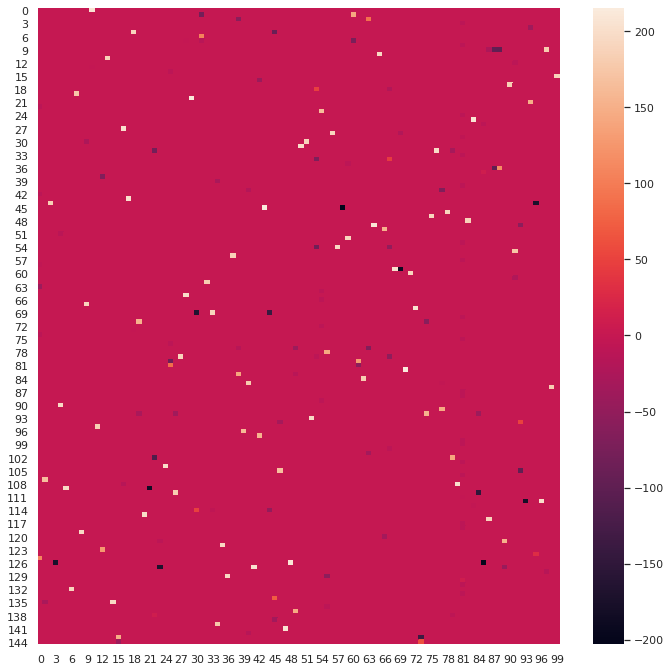

In [ ]:
import seaborn as sns; sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,11.7)})

assign_matrix = matrix
for i, j in zip(row_ind, col_ind):
  assign_matrix[i][j] = -matrix[i][j]
    
ax = sns.heatmap(assign_matrix)

e600_bi_regre.pkl  
Method2   
209 100 100 100  
correct/total: 23047/30188 76.34490526036835%  
accuracy: 38.491943604250295  
precision: 74.72309661447825  
accept rate: 72.0  
Method1  
213 100 100 100  
correct/total: 22902/30188 75.86458195309395%  
accuracy: 37.87986569569403  
precision: 73.81822461125425  
accept rate: 70.0  

e700_regre  
Method2  
209 100 100 100  
correct/total: 23048/30188 76.34821783490129%  
accuracy: 38.8330983798389  
precision: 75.03086731473734  
accept rate: 71.0  
Method1  
213 100 100 100  
correct/total: 22568/30188 74.75818205909633%  
accuracy: 37.734853537063614  
precision: 73.18178885235189  
accept rate: 68.0  

e400_bi_regre_2.pkl
Method2    
145 100 100 100  
correct/total: 15173/19727 76.91488822426116%  
accuracy: 54.137741910621514  
precision: 76.75477183848903  
accept rate: 78.0 

e950_regre_2.pkl  
Method2  
145 100 100 100  
correct/total: 14775/19727 74.89734881127389%  
accuracy: 53.63339798744716  
precision: 74.81218519998812  
accept rate: 75.0  

In [ ]:
"""
Precision: How much percentage of the grouped ids are really from one group
"""

DEBUG = True
walker_ids = set(df_walks_connected['walker_id'].tolist())
correct, total = 0, 0
if DEBUG: print(len(walker_ids))
    
for walker_id in walker_ids:
    id_list = df_walks_connected.loc[df_walks_connected['walker_id'] == walker_id].sort_values('walk_time')['real_id'].tolist()
    dic = collections.Counter(id_list)
    
    l = max(dic.values())
    key = [k for k,v in dic.items() if v == l]
    
    correct += l
    total += sum(dic.values())

# print(f'correct/tried: {correct}/{tried} {correct/tried*100}%') 
print(f'correct/total: {correct}/{total} {correct/total*100}%')

145
correct/total: 15741/19727 79.79419070309729%


In [ ]:
"""
Accuracy: How much percentage of one group is correctly grouped together (only consider the largest sub-group of grouped ids)
"""

DEBUG = False
real_ids = set(df_walks_connected['real_id'].tolist())
correct, total = 0, 0
for real_id in real_ids:
    id_list = df_walks_connected.loc[df_walks_connected['real_id'] == real_id].sort_values('walk_time')['walker_id'].tolist()
    dic = collections.Counter(id_list)
    if DEBUG: print(id_list)
    
    l = max(dic.values())
    key = [k for k,v in dic.items() if v == l]
    
    correct += l
    total += sum([v for v in dic.values()])
#     df_walks_connected = df_walks_connected.replace({'walker_id': {key[0]: real_id}})
# print(f'base: {total - (150 / 10 - 1) * 10}/{total} {(total - (150 / 10 - 1) * 10)/total*100}')
# print(f'correct/tried: {correct}/{tried} {correct/tried*100}%') 
print(f'correct/total: {correct}/{total} {correct/total*100}%')

correct/total: 17019/19727 86.27262128047853%


In [ ]:
DEBUG = False
real_ids = set(df_walks_connected['real_id'].tolist())
correct, total = 0, 0
visited = set()
for real_id in real_ids:
    id_list = df_walks_connected.loc[df_walks_connected['real_id'] == real_id].sort_values('walk_time')['walker_id'].tolist()
    dic = collections.Counter(id_list)
    if DEBUG: print(id_list)
    
    l = max(dic.values())
    p = [v for k,v in dic.items() if v == l][0] / sum(dic.values())
    if p > 0.6:
      correct += 1
    
#     df_walks_connected = df_walks_connected.replace({'walker_id': {key[0]: real_id}})
# print(f'base: {total - (150 / 10 - 1) * 10}/{total} {(total - (150 / 10 - 1) * 10)/total*100}')
# print(f'correct/tried: {correct}/{tried} {correct/tried*100}%') 
print(f'correct/total: {correct}/{len(real_ids)} {correct/len(real_ids)*100}%')

correct/total: 88/100 88.0%


In [ ]:
cnx.execute('DROP TABLE IF EXISTS walks_attached')
df_walks_connected.to_sql('walks_attached', con=cnx)

# Compute Other Info

In [ ]:
id = '1tmp'
path = df_walks_connected.loc[df_walks_connected['walker_id'] == id].sort_values('walk_time')

In [ ]:
for (indx1,row1),(indx2,row2) in zip(path[:-1].iterrows(),path[1:].iterrows()):
    jsondict1, jsondict2 = json.loads(row1['json']), json.loads(row2['json'])
    agent_id1, agent_id2 = pos_to_id[(jsondict1['position']['x'], jsondict1['position']['y'])], 
    pos_to_id[(jsondict2['position']['x'], jsondict2['position']['y'])]
    